# <u> Strategy 1a : Moving Average </u>

### <u> Preleminaries </u>

Importing libraries necessary to the project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from itertools import combinations

importing our custom hepful functions:

In [2]:
from backtesting.backtesting import backtest
from data_retrieval.data_retrieval import fetch_tickers

In [11]:
fetch_tickers(['MSFT','AAPL','AMZN'],'nasdaq','2000-01-01','2020-12-31' )

,Date,MSFT,AAPL,AMZN
0,2000-01-01,NaN,NaN,NaN
1,2000-01-02,NaN,NaN,NaN
2,2000-01-03,36.932102,0.851942,4.468750
3,2000-01-04,35.684532,0.780115,4.096875
4,2000-01-05,36.060772,0.791531,3.487500
...,...,...,...,...
7666,2020-12-27,NaN,NaN,NaN
7667,2020-12-28,223.925995,135.068573,164.197998
7668,2020-12-29,223.119720,133.270157,166.100006
7669,2020-12-30,220.661072,132.133820,164.292496


### <u> 1 - Example Data </u>

Daily Microsoft Stock Data (Adjusted Close) from 2000 onwards

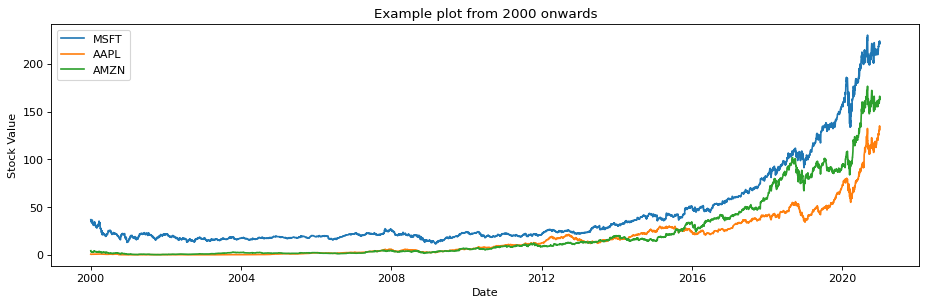

In [3]:
#Fetching Data:
tickers = ['MSFT','AAPL','AMZN']
data = fetch_tickers(tickers, 'nasdaq', '2000-01-01', '2020-12-31').dropna()

#Plotting:
plt.figure(figsize=(14, 4), dpi=80)
for ticker in tickers:
    plt.plot(data['Date'],data[ticker], label=ticker)
plt.ylabel('Stock Value')
plt.xlabel('Date')
plt.title('Example plot from 2000 onwards')
plt.legend()
plt.show()

### <u> 2 - Moving Average Crossovers </u>

Computing the moving average crossovers for all tickers at every point in time : 

In [4]:
# Range of moving average lookback periods
lookback_range = [5, 10, 20, 50, 100, 150, 200, 300, 400, 500]

# Generate all unique pairs (a, b) where a < b
unique_pairs = list(combinations(lookback_range, 2))

# Precompute all SMA and EMA for all lookback periods
sma_data = {n: data[tickers].rolling(window=n).mean() for n in lookback_range}
ema_data = {n: data[tickers].ewm(span=n, adjust=False).mean() for n in lookback_range}

# Computing all moving average crossovers
MA_Crossovers = {}
for ticker in tickers:
    crossover_results = []
    
    for a, b in unique_pairs:
        # Retrieve precomputed SMA/EMA for this ticker
        sma_a = sma_data[a][ticker]
        sma_b = sma_data[b][ticker]
        ema_a = ema_data[a][ticker]
        ema_b = ema_data[b][ticker]

        # Compute SMA crossover signals
        sma_diff_prev = (sma_a - sma_b).shift(1)  # Previous difference
        sma_diff_curr = (sma_a - sma_b)           # Current difference
        sma_crossover = (((sma_diff_prev < 0) & (sma_diff_curr > 0)).astype(int) -
                         ((sma_diff_prev > 0) & (sma_diff_curr < 0)).astype(int))  

        # Compute EMA crossover signals
        ema_diff_prev = (ema_a - ema_b).shift(1)  # Previous difference
        ema_diff_curr = (ema_a - ema_b)           # Current difference
        ema_crossover = (((ema_diff_prev < 0) & (ema_diff_curr > 0)).astype(int) -
                         ((ema_diff_prev > 0) & (ema_diff_curr < 0)).astype(int))

        # Store results
        crossover_results.append(pd.DataFrame({
            f'SMA_crossover_{a}_{b}': sma_crossover,
            f'EMA_crossover_{a}_{b}': ema_crossover
        }))

    # Combine all results for the ticker
    MA_Crossovers[ticker] = pd.concat(crossover_results, axis=1)
    MA_Crossovers[ticker].insert(0, 'Date', data['Date'])  # Add the Date column
    MA_Crossovers[ticker].dropna(inplace=True)  # Drop rows with NaN


Visualizing the results : 

In [5]:
# Initialize an empty DataFrame to store the results
summary_df = pd.DataFrame()

# Iterate through each ticker's DataFrame
for ticker, df in MA_Crossovers.items():
    # Collect value counts for each crossover column
    ticker_summary = {"Ticker": ticker}
    for col in df.columns:
        if "crossover" in col:  # Check if the column is a crossover indicator
            # Count +1 (upward crossovers) and -1 (downward crossovers)
            upward_count = df[col].value_counts().get(1, 0)
            downward_count = df[col].value_counts().get(-1, 0)
            ticker_summary[f'{col}_upward'] = upward_count
            ticker_summary[f'{col}_downward'] = downward_count
    
    # Append results to the summary DataFrame
    summary_df = pd.concat([summary_df, pd.DataFrame([ticker_summary])], ignore_index=True)

# Display the summary DataFrame
summary_df

,Ticker,SMA_crossover_5_10_upward,SMA_crossover_5_10_downward,EMA_crossover_5_10_upward,EMA_crossover_5_10_downward,SMA_crossover_5_20_upward,SMA_crossover_5_20_downward,EMA_crossover_5_20_upward,EMA_crossover_5_20_downward,SMA_crossover_5_50_upward,...,EMA_crossover_300_400_upward,EMA_crossover_300_400_downward,SMA_crossover_300_500_upward,SMA_crossover_300_500_downward,EMA_crossover_300_500_upward,EMA_crossover_300_500_downward,SMA_crossover_400_500_upward,SMA_crossover_400_500_downward,EMA_crossover_400_500_upward,EMA_crossover_400_500_downward
0,MSFT,299,298,230,229,160,159,159,158,90,...,3,2,3,2,3,2,5,4,3,2
1,AAPL,269,268,203,202,149,149,146,145,86,...,3,2,4,3,3,2,5,4,2,1
2,AMZN,284,283,213,212,162,161,147,146,81,...,4,3,4,3,2,1,5,4,2,1


Plotting a specific strategy:

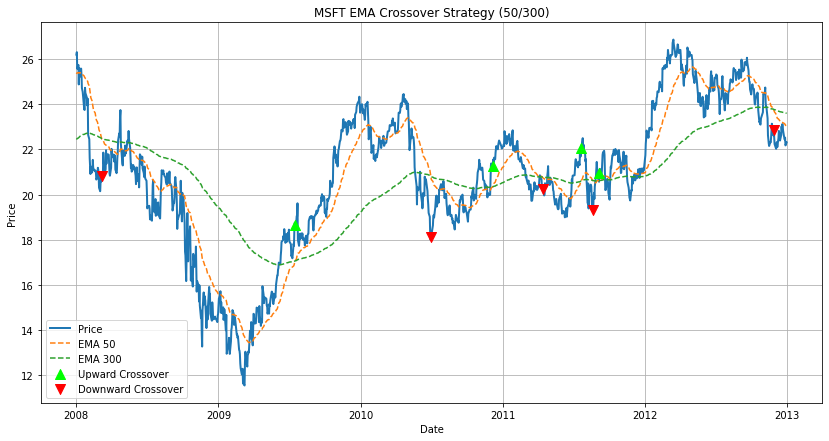

In [6]:
# Select strategy
example_ticker = 'MSFT'
EMA_or_SMA = 'EMA'  # 'SMA' or 'EMA'
example_long_MA = 300
example_short_MA = 50
start_date = '2008-01-01'
end_date = '2013-01-01'

# Get strategy name
example_strategy_name = f'{EMA_or_SMA}_crossover_{example_short_MA}_{example_long_MA}'
example_crossover_df = MA_Crossovers[example_ticker]
example_data = data[['Date', example_ticker]].copy()

# Compute the selected moving averages
if EMA_or_SMA == 'SMA':
    example_data[f'{example_ticker}_SMA_{example_short_MA}'] = example_data[example_ticker].rolling(window=example_short_MA).mean()
    example_data[f'{example_ticker}_SMA_{example_long_MA}'] = example_data[example_ticker].rolling(window=example_long_MA).mean()
elif EMA_or_SMA == 'EMA':
    example_data[f'{example_ticker}_EMA_{example_short_MA}'] = example_data[example_ticker].ewm(span=example_short_MA, adjust=False).mean()
    example_data[f'{example_ticker}_EMA_{example_long_MA}'] = example_data[example_ticker].ewm(span=example_long_MA, adjust=False).mean()

# Merge crossover signals with the data
example_df = pd.merge(
    example_crossover_df[['Date', example_strategy_name]],
    example_data,
    on='Date'
).dropna()

# Filter data within the desired date range
example_df = example_df[(example_df['Date'] >= start_date) & (example_df['Date'] <= end_date)]

# Plotting the strategy
plt.figure(figsize=(14, 7))
plt.plot(example_df['Date'], example_df[example_ticker], label='Price', linewidth=2)
plt.plot(
    example_df['Date'], 
    example_df[f'{example_ticker}_{EMA_or_SMA}_{example_short_MA}'], 
    label=f'{EMA_or_SMA} {example_short_MA}', 
    linestyle='--'
)
plt.plot(
    example_df['Date'], 
    example_df[f'{example_ticker}_{EMA_or_SMA}_{example_long_MA}'], 
    label=f'{EMA_or_SMA} {example_long_MA}', 
    linestyle='--'
)

# Highlight crossover points with scatter markers
upward_crossovers = example_df[example_df[example_strategy_name] == 1]
downward_crossovers = example_df[example_df[example_strategy_name] == -1]

plt.scatter(
    upward_crossovers['Date'], 
    upward_crossovers[example_ticker], 
    color='lime', 
    marker='^', 
    label='Upward Crossover',
    s=100,
    zorder=5
)
plt.scatter(
    downward_crossovers['Date'], 
    downward_crossovers[example_ticker], 
    color='red', 
    marker='v',
    s=100,
    label='Downward Crossover', 
    zorder=5
)

# Final touches
plt.title(f'{example_ticker} {EMA_or_SMA} Crossover Strategy ({example_short_MA}/{example_long_MA})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


### <u> 3 - Moving Average Crossover Strategies </u>

#### <u> 3.1 - BUY and HOLD </u>

this establishes our baseline of returns.

In [7]:
#Indexing the data with the dates
data_indexed = data.set_index('Date') 

# Calculate percentage change (daily returns)
BAH_returns = data_indexed.pct_change().fillna(0)

# Calculate cumulative returns
BAH_cum_returns = (1 + BAH_returns).cumprod() - 1

# Display the result
BAH_cum_returns

,MSFT,AAPL,AMZN
Date,,,
2000-01-03,0.000000,0.000000,0.000000
2000-01-04,-0.033780,-0.084310,-0.083217
2000-01-05,-0.023593,-0.070911,-0.219580
2000-01-06,-0.056300,-0.151313,-0.266434
2000-01-07,-0.043968,-0.111111,-0.221678
...,...,...,...
2020-12-24,5.003616,152.067375,34.498631
2020-12-28,5.063180,157.541926,35.743608
2020-12-29,5.041349,155.430966,36.169232


#### <u> 3.2 - Reversal Strategy </u>

This strategy is characterized by going long when the long moving averages goes above the short moving average and going short otherwise.

In [8]:
# Initialize a dictionary to store results for all tickers
pnl_results = {}
pnl_cumulative_results = {}

# Loop through each ticker
for ticker in tickers:
    crossover_df = MA_Crossovers[ticker].set_index('Date')  # Ensure the index is Date
    price_series = data[['Date', ticker]].set_index('Date')  # Ensure the index is Date
    returns = price_series.pct_change().fillna(0)  # Calculate daily returns and handle NaN
    
    # Forward-fill positions to maintain the last signal
    position_matrix = crossover_df.copy().shift(1)  # Shift signals to apply on the next day
    position_matrix = position_matrix.fillna(0).replace(0, method='ffill')  # Fill gaps after the shift

    # Synchronize indices between position_matrix and returns
    position_matrix = position_matrix.reindex(returns.index, method='ffill')  # Align indices with returns

    # Calculate PnL by multiplying positions with returns
    pnl_matrix = position_matrix * returns[ticker].values.reshape(-1, 1)

    # Store results for this ticker
    pnl_results[ticker] = pnl_matrix
    pnl_cumulative_results[ticker] = (1 + pnl_results[ticker]).cumprod() - 1


In [9]:
pnl_cumulative_results['AMZN']

,SMA_crossover_5_10,EMA_crossover_5_10,SMA_crossover_5_20,EMA_crossover_5_20,SMA_crossover_5_50,EMA_crossover_5_50,SMA_crossover_5_100,EMA_crossover_5_100,SMA_crossover_5_150,EMA_crossover_5_150,...,SMA_crossover_200_400,EMA_crossover_200_400,SMA_crossover_200_500,EMA_crossover_200_500,SMA_crossover_300_400,EMA_crossover_300_400,SMA_crossover_300_500,EMA_crossover_300_500,SMA_crossover_400_500,EMA_crossover_400_500
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-0.985128,-0.894499,-0.988180,-0.800118,-0.044935,-0.516629,-0.519115,-0.798444,-0.707529,-0.198931,...,0.927158,7.130982,2.423763,7.552494,0.371243,4.799836,5.169390,21.980986,1.996355,15.276683
2020-12-28,-0.984607,-0.890799,-0.987765,-0.793108,-0.011439,-0.499677,-0.535980,-0.791375,-0.697271,-0.170837,...,0.994745,7.416144,2.543839,7.852440,0.419334,5.003243,5.385758,22.786955,2.101440,15.847525
2020-12-29,-0.984428,-0.889534,-0.987624,-0.790711,0.000012,-0.493881,-0.530605,-0.788958,-0.693765,-0.161232,...,1.017852,7.513634,2.584889,7.954983,0.435775,5.072782,5.459728,23.062494,2.137366,16.042680


BUY and HOLD vs reversal on a specific stock :

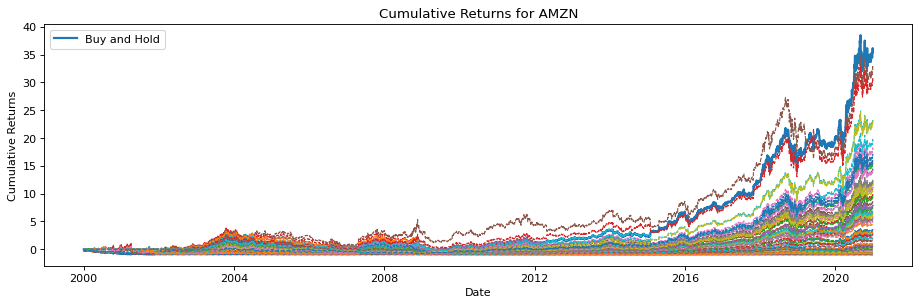

In [10]:
example_stock = 'AMZN'

# Merge Buy and Hold (BAH) cumulative returns with crossover strategy cumulative returns
example_df = pd.merge(
    BAH_cum_returns[example_stock], 
    pnl_cumulative_results[example_stock], 
    on='Date'
)

# Plotting
plt.figure(figsize=(14, 4), dpi=80)

# Plot Buy and Hold (solid line)
plt.plot(
    example_df.index, 
    example_df[BAH_cum_returns[example_stock].name], 
    label='Buy and Hold', 
    linestyle='-', 
    linewidth=2
)

# Plot each crossover strategy (dashed lines)
for column in pnl_cumulative_results[example_stock].columns:
    plt.plot(
        example_df.index, 
        example_df[column], 
        linestyle='--', 
        linewidth=1
    )

# Add labels, legend, and show the plot
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title(f'Cumulative Returns for {example_stock}')
plt.legend()
plt.show()


#### <u> 3.2 - Directional Long Only </u>